In [13]:
# load libraries
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import numpy as np
from keras.datasets import mnist
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# input image dimensions
img_rows, img_cols = 28, 28
#set CNN parameters
batch_size = 100
num_classes = 10
epochs = 5
FC_SIZE = 256
classes = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                    'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [14]:
np.set_printoptions(precision=2)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
       
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
# read training and test sets
data=np.load("FashionData/FashionPDEngDM.npz")

##Labeled training set for classes 1,2,3,8,9 (30000 samples)
x_train_12389_labeled=data["x_train_12389_labeled"]
y_train_12389_labeled=data["y_train_12389_labeled"]

##Labeled training set for classes 0,4,5,6,7 (just 5 samples)
x_train_04567_labeled=data["x_train_04567_labeled"]
y_train_04567_labeled=data["y_train_04567_labeled"]

##Unlabeled training set for classes 0,4,5,6,7 (29992 samples)
x_train_04567_unlabeled=data["x_train_04567_unlabeled"]

##Labeled test set for classes 1,2,3,8,9
x_test_12389=data["x_test_12389"]
y_test_12389=data["y_test_12389"]

##Labeled test set for classes 0,4,5,6,7 (this is where we are interested to obtain the highest accuracy possible - project goal)
x_test_04567=data["x_test_04567"]
y_test_04567=data["y_test_04567"]

def preprocess_data(X, y):
    #create tensor variant of 2D images
    if K.image_data_format() == 'channels_first':
        X = X.reshape(X.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X = X.reshape(X.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    X = X.astype('float32') / 255
    #X = (X - np.mean(X)) / np.std(X)
    # convert class vectors to binary class matrices
    y = keras.utils.to_categorical(y, num_classes)
    return X, y, input_shape

x_train_12389_labeled, y_train_12389_labeled, input_shape = preprocess_data(x_train_12389_labeled, y_train_12389_labeled)
x_test_12389, y_test_12389, _ = preprocess_data(x_test_12389, y_test_12389)

x_train_04567_labeled, y_train_04567_labeled, input_shape = preprocess_data(x_train_04567_labeled, y_train_04567_labeled)
x_test_04567, y_test_04567, _ = preprocess_data(x_test_04567, y_test_04567)

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
x_train_mnist, y_train_mnist, _ = preprocess_data(x_train_mnist, y_train_mnist)
x_test_mnist, y_test_mnist, _ = preprocess_data(x_test_mnist, y_test_mnist)

In [16]:
input_shape

(28, 28, 1)

In [17]:
### 
x_train_much = x_train_mnist
y_train_much = y_train_mnist

x_test_much = x_test_mnist
y_test_much = y_test_mnist

# x_train_much = x_train_12389_labeled
# y_train_much = y_train_12389_labeled

# x_test_much = x_test_12389
# y_test_much = y_test_12389

x_train_little = x_train_04567_labeled
y_train_little = y_train_04567_labeled

x_test_little = x_test_04567
y_test_little = y_test_04567

target_names_little = classes[np.unique(np.argmax(y_test_little, axis = 1))]
clasess_much = np.unique(np.argmax(y_test_much, axis = 1))
target_names_much = classes[clasess_much]

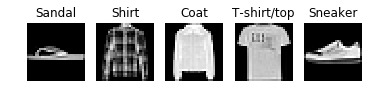

In [18]:
# Plotting little data
f, axarr = plt.subplots(1, 5)
for i in range(len(x_train_little)):
    axarr[i].imshow(x_train_little[i].reshape((28,28)), cmap='gray')
    axarr[i].set_title(classes[np.argmax(y_train_little[i])])
    axarr[i].axis('off')
plt.show()

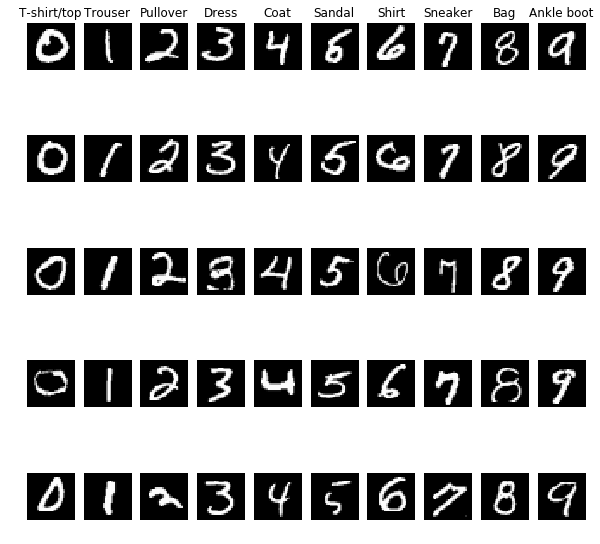

In [19]:
# Plotting little data
samples_per_class = 5
num_classes = len(clasess_much)
f, axarr = plt.subplots(samples_per_class, num_classes, figsize=(10,10))
#class_i = np.argmax(y_train_much[i]) 

for i, class_i in enumerate(clasess_much):
    idxs = np.flatnonzero(np.argmax(y_train_much, axis =1) == class_i)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for j, idx in enumerate(idxs):
        #plt_idx = i * num_classes + y + 1
        axarr[j, i].imshow(x_train_much[idx].reshape((28,28)), cmap='gray')
        axarr[j, i].axis('off')
        #plt.axis('off')
        if j == 0:
            axarr[j, i].set_title(classes[class_i])
plt.show()
#x_test_little[0].shape.

In [21]:
# image augumentation
rotation_range = 30
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0
fill_mode = 'nearest'
img_aug_much_train = ImageDataGenerator(
    rotation_range = rotation_range,
    shear_range = shear_range,
    width_shift_range= width_shift_range,
    height_shift_range= height_shift_range,
    fill_mode = fill_mode
)

img_aug_little_train = ImageDataGenerator(
    rotation_range = rotation_range,
    width_shift_range= width_shift_range,
    height_shift_range= height_shift_range,
    fill_mode = fill_mode,
    #shear_range = 0.2
    #horizontal_flip = True
)

img_aug_much_train.fit(x_train_much)
img_aug_little_train.fit(x_train_little)

In [25]:
input_shape

(28, 28, 1)

In [26]:
def train_base_model(model_name):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
#     model.add(Conv2D(128, (3, 3), activation='relu')) #new
#     model.add(MaxPooling2D(pool_size=(2, 2))) #new
#     model.add(Dropout(0.25))#new
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    #     model.fit_generator( 
    #               img_aug_much_train.flow(x_train_little, y_train_little, batch_size=batch_size),
    #               steps_per_epoch = len(x_train_little) / batch_size,
    #               epochs = epochs,
    #               verbose = 1#,
    #               #validation_data = (x_test_little, y_test_little)
    #     )
    
    model.fit( 
              x_train_much,
              y_train_much,
              batch_size=batch_size,
              epochs = epochs#,
              #validation_data = (x_test_little, y_test_little)
    )

    score = model.evaluate(x_train_much, y_train_much)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model.save(model_name)
train_base_model(model_name = '12389_templ_2conv.h5')

Epoch 1/5
 2800/60000 [>.............................] - ETA: 145s - loss: 1.0776 - acc: 0.6414

KeyboardInterrupt: 

NameError: name 'random' is not defined

In [6]:
# load saved based model
base_model = keras.models.load_model('mnist_template.h5')

Normalized confusion matrix
[[ 0.98  0.    0.01  0.    0.  ]
 [ 0.    0.97  0.03  0.    0.  ]
 [ 0.    0.01  0.99  0.    0.  ]
 [ 0.    0.    0.01  0.98  0.  ]
 [ 0.    0.    0.    0.    1.  ]]


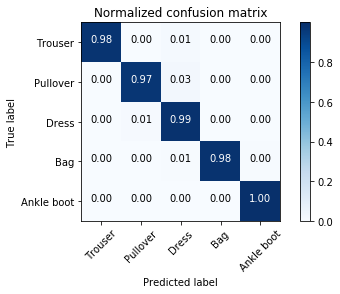

In [122]:
#evaluation of the base model
y_pred_proba = base_model.predict(x_test_much)
y_pred_classes = np.argmax(y_pred_proba, axis=1) # Convert one-hot to index

y_test_much_class = np.argmax(y_test_much, axis=1)

target_names = classes[np.unique(y_test_much_class)]

#print(classification_report(y_test_little_class, y_pred_classes, target_names = target_names))
cm = confusion_matrix(y_test_much_class, y_pred_classes)
plt.figure()
plot_confusion_matrix(cm, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [90]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 5, 128)         0         
__________

In [7]:
# preparing transfer model
for layer in base_model.layers:
    layer.trainable = False #turn of all layers for training

#base_model.layers[2].trainable = True
base_model.layers[1].trainable = True
#base_model.layers[4].trainable = True
#base_model.layers[4]

# adding a dense layer behind flatten_1 layers (i.e., layer[-4])
x = Dense(128, activation='relu', name = "dense_new1")(base_model.layers[-4].output)  
x = Dropout(0.5, name='dropout_new')(x)  
predictions = Dense(num_classes, activation='softmax', name='softmax_new1')(x)  # new softmax layer
transfer_model = Model(input=base_model.input, output=predictions)
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_new1 (Dense)           (None, 128)               1179776   
__________

C:\Users\azika\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("so...)`


In [8]:
# training transfer model
transfer_model_epochs = 500
RMSprop_default_learning = 0.001
transfer_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.RMSprop(lr = RMSprop_default_learning * 0.1),
              metrics=['accuracy'])
# transfer_model.fit_generator(
#           img_aug_little_train.flow(x_train_little, y_train_little, batch_size=batch_size),
#           steps_per_epoch = len(x_train_little) / batch_size,
#           epochs = transfer_model_epochs,
#           shuffle=True,
#           #verbose=1
#           #validation_data = (x_test_little, y_test_little)
#     )

transfer_model.fit(
          x_train_little, 
          y_train_little, 
          batch_size=batch_size,
          epochs = transfer_model_epochs,
          shuffle=True,
          verbose=1
)

score = transfer_model.evaluate(x_test_little, y_test_little)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
transfer_model.save('transfer_model.h5')

Epoch 1/500
5/5 [==============================] - 0s - loss: 2.2417 - acc: 0.2000
Epoch 2/500
5/5 [==============================] - 0s - loss: 2.2874 - acc: 0.2000
Epoch 3/500
5/5 [==============================] - 0s - loss: 2.2157 - acc: 0.0000e+00
Epoch 4/500
5/5 [==============================] - 0s - loss: 2.2658 - acc: 0.2000
Epoch 5/500
5/5 [==============================] - 0s - loss: 2.1134 - acc: 0.4000
Epoch 6/500
5/5 [==============================] - 0s - loss: 2.0810 - acc: 0.6000
Epoch 7/500
5/5 [==============================] - 0s - loss: 2.0976 - acc: 0.0000e+00
Epoch 8/500
5/5 [==============================] - 0s - loss: 2.0724 - acc: 0.2000
Epoch 9/500
5/5 [==============================] - 0s - loss: 1.9749 - acc: 0.6000
Epoch 10/500
5/5 [==============================] - 0s - loss: 2.0288 - acc: 0.2000
Epoch 11/500
5/5 [==============================] - 0s - loss: 2.0338 - acc: 0.4000
Epoch 12/500
5/5 [==============================] - 0s - loss: 1.8817 - acc: 

Normalized confusion matrix
[[ 0.88  0.02  0.01  0.09  0.  ]
 [ 0.13  0.73  0.    0.14  0.  ]
 [ 0.01  0.    0.28  0.24  0.48]
 [ 0.35  0.34  0.    0.31  0.  ]
 [ 0.    0.    0.03  0.    0.97]]


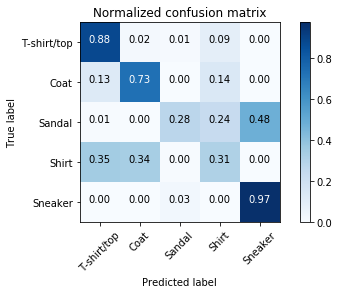

In [9]:
y_pred_proba = transfer_model.predict(x_test_little)
y_pred_classes = np.argmax(y_pred_proba, axis=1) # Convert one-hot to index
y_test_little_class = np.argmax(y_test_little, axis=1)

target_names = classes[np.unique(y_test_little_class)]
#print(classification_report(y_test_little_class, y_pred_classes, target_names = target_names))
cm = confusion_matrix(y_test_little_class, y_pred_classes)
plt.figure()
plot_confusion_matrix(cm, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()